# DeepAR: Web Traffic Time Series Forecasting
   by Anton Markov, [linked-in](https://www.linkedin.com/in/markov-anton/)

## Problem 
- ML competition, [Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting)
- forecasting future web traffic for approximately 145,000 Wikipedia articles
- 802 daily values in each time series (max) 
- input: article name and time series values

## Outline
- provide categorical and dynamic features, <font color=green>OK</font>
- LOO validation schema, <font color=green>OK</font>
- use custom validation metric SMAPE, <font color=green>OK</font>
- provide baseline model, <font color=green>OK</font>
- HP tuning, <font color=orange>pending</font>
- complte dataset predictions, <font color=orange>pending</font>

## Code

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import re
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import math
import json

jtplot.style()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000)

## Data read
- limit history data to 1 year

In [10]:
dataset_path = 'input/train_2.csv'

train_len = 365
validation_len = 62
prediction_len = 62

data_set_max_date = pd.Timestamp('2017-09-10')
data_set_first_date = data_set_max_date - pd.Timedelta(days=train_len+validation_len-1)
test_first_date = data_set_max_date - pd.Timedelta(days=validation_len-1)
prediction_start = pd.Timestamp('2017-09-13')

In [11]:
dataset = pd.read_csv(dataset_path)

# Rotate data to get master data set
master_df = dataset.melt(id_vars='Page', var_name='date', value_name='Visits')
master_df['date'] =  pd.to_datetime(master_df['date'])

master_df = master_df[master_df['date'] >= data_set_first_date]

## EDA

In [12]:
dataset.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

#### Lets see distribution
- scale-free nature of TS

<font size=-1>*One challenge often encountered when attempting to jointly learn from multiple time series in realworld forecasting problems is that the magnitudes of the time series differ widely, and the distribution of the magnitudes is strongly skewed. (DeepAR paper)*</font>

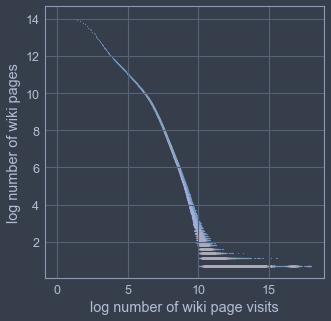

In [13]:
def draw_distrib():
    df = master_df[master_df['Visits'].notna()]
    gr = df.groupby('Visits')['Page'].count()
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=np.log1p(gr.index), y=np.log1p(gr), s=1)
    plt.xlabel('log number of wiki page visits')
    plt.ylabel('log number of wiki pages')
draw_distrib()   

## Features engineering
- DeepAR tolerates mininal FE
- generating text features out of article name can be challenging. Titles are multi language! BOF/n-grams too long and sparce, Embeddings/TF-IDF are floats
- SMAPE fails dramatically if not using any FE

#### Prepare categorical features
- all categories should be listed in train dataset
- single coarse feature to for model to learn embeddings (DeepAR paper)

In [14]:
#  52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider

def get_lang(page):
    page_title = page[:page[:page.rfind('.')].rfind('.')]
    page_title = re.sub('[0-9!"\?\.)(,\+\*\[\]/:;\-\'&_]', ' ', page_title)
    lang = page_title[page_title.rfind('_')-1:]
    if lang == 'ww':
        lang = 'en'
    return lang
    
def get_access_category(page):
    return page.split('.')[-1]

def get_domain(page):
    return page.split('.')[-2]

def get_page_categorical_features(pages_sr):
    page_features = pd.DataFrame(pages_sr)
    page_features['lang'] = pages_sr.apply(get_lang)
    page_features['access_cat'] = pages_sr.apply(get_access_category)
    page_features['domain'] = pages_sr.apply(get_domain)
    
    page_features['cat'] = page_features[['lang', 'access_cat', 'domain']]\
            .apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    page_features['cat'] = LabelEncoder().fit_transform(page_features['cat'])
    page_features = page_features.drop(columns=['lang', 'access_cat', 'domain'])    
    page_features = page_features.set_index('Page')
    return page_features
page_features = get_page_categorical_features(dataset['Page'])

#### Prepare dynamic features
- according to DeepAR paper recomendations

In [16]:
def get_dynamic_features(dates):
    ts_age = [(date - data_set_first_date).days for date in dates]    
    days_of_week = [date.dayofweek for date in dates] 
    day_of_year = [date.dayofyear for date in dates] 
    week_of_year = [date.week for date in dates] 
    return [ts_age, days_of_week, day_of_year, week_of_year]  

#### Preparing data for model

#### Tran/test split
- use 1y of history data
- cross join Page names with date range to generate continuous TS
- StratifiedShuffleSplit for uniforn test/validation split

![Data](img/data.png)

In [17]:
def split_pages(dataset_df, cat_feature_df): 
    dataset_df = dataset_df.merge(cat_feature_df, on='Page', how='left')
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
    train_index, test_index = [(train_index, test_index) for train_index, test_index \
                               in split.split(dataset_df, dataset_df['cat'])][0]
    return dataset.iloc[train_index]['Page'], dataset.iloc[test_index]['Page']

In [18]:
def get_split(date_start, date_end, pages, master_df):
    days_range = pd.date_range(start=date_start, end=date_end)
    grid = pd.DataFrame(pages, columns=['Page'])
    grid = grid.merge(pd.DataFrame(days_range, columns=['date']), how='cross')
    grid = grid.merge(master_df, on=['Page', 'date'], how='left')
    return grid

In [21]:
train_pages, test_pages = split_pages(dataset, page_features)
train = get_split(data_set_first_date, test_first_date - pd.Timedelta(days=1),
                 train_pages, master_df)
test = get_split(data_set_first_date, test_first_date - pd.Timedelta(days=1),
                 test_pages, master_df)

In [22]:
del dataset

#### Aggregate time series
- aggregate TS by page
- apply categorical and dynamic features
- adjust to start time. Needed for DeepAR to learn features
- shuffle rows as per DeepAR requirement

In [23]:
def aggregate_ts(df, start_date, prediction_start_date=None, end_date=None):
    def apply_features(row):
        row['cat'] = [page_features.loc[row['Page']]['cat']]
        start = 0
        while (start < len(row['Visits']) and np.isnan(row['Visits'][start])):
            start += 1    
        if start < len(row['date']) \
                       and (not prediction_start_date or row['date'][start]<prediction_start_date):
            row['start'] = row['date'][start]
            row['dynamic_feat'] = get_dynamic_features(row['date'][start:])
            row['target'] = row['Visits'][start:]
            row['target'] = [v if ~np.isnan(v) else 'NaN' for v in row['target']]
        else:
            row['start'] = prediction_start_date if prediction_start_date else start_date
            row['dynamic_feat'] = get_dynamic_features(pd.date_range(start=prediction_start_date, 
                                                                     end=end_date)) \
                                    if prediction_start_date else [[],[],[],[]]
            row['target'] = []
        return row
    df = df.sort_values(by=['date'])
    df = df.groupby(['Page'], as_index=False)\
        .agg({'date': lambda x: x.tolist(), 'Visits':lambda x: x.tolist()})
    df = df.apply(apply_features, axis=1)
    df['start'] = df['start'].dt.strftime('%Y-%m-%d %M:%M:%M')
    return df.drop(columns=['Page', 
        'date', 'Visits']).sample(frac=1)

def df_to_jlines(df, file_name):
    with open(f'./output/{file_name}.json', 'w') as f:
        f.write(df.to_json(orient='records', lines=True))

##### Aggregating and saving to files
- use json lines format for Sagemaker batch transform jobs

In [24]:
test_agg = aggregate_ts(test, data_set_first_date)
df_to_jlines(test_agg, 'test')
train_agg = aggregate_ts(train, data_set_first_date)
df_to_jlines(train_agg, 'train')

## Model training in DeepAR
- all defaults, 10 epochs

## Model evaluation using SMAPE*
<font size=-1>*Symmetric mean absolute percentage error is an accuracy measure based on percentage (or relative) errors*</font>

*code taken from Kaggle

In [25]:
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = float(y_true[i])
        b = float(y_pred[i])
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

#### Baseline model (persist a mean of last 14 days)

In [29]:
test_covariates = test[test['date'] < test_first_date]
test_target = test[test['date'] >= test_first_date]

test_window = test_covariates[test_covariates['date']  > (test_first_date - pd.Timedelta(days=14))]
means = test_window.groupby('Page', as_index=False)['Visits'].mean()
means['y_hat'] = means['Visits'].apply(lambda x: [round(x, 1)] * validation_len)
test_target = get_split(test_first_date, data_set_max_date, test['Page'].unique(), master_df)
test_target = test_target.groupby('Page')['Visits']\
    .agg(lambda V: [v if ~np.isnan(v) else 0 for v in V])
X_y = means
X_y['y'] = X_y['Page'].map(test_target)
base_model_smape = X_y[['y_hat', 'y']].apply(
    lambda row : smape_fast(np.array(row['y_hat']), np.array(row['y'])), axis=1).mean()
print(f'Base model SMAPE = {base_model_smape}')

Base model SMAPE = 43.83532160321394


#### Prepare evaluation file to predict using DeepAR
- cut last 62 targets of test set

In [27]:
evaluation = get_split(data_set_first_date, data_set_max_date, test_pages, master_df)
evaluation_agg = aggregate_ts(evaluation, data_set_first_date,
                              prediction_start_date=test_first_date, end_date=data_set_max_date)
evaluation_agg['y'] = evaluation_agg['target'].str[-prediction_len:]
evaluation_agg['target'] = evaluation_agg['target'].str[:-prediction_len]
df_to_jlines(evaluation_agg.drop(columns=['y']), 'evaluation')

##### Reading DeepAR predictions and evaluating
- prediction is produced by Sagemaker batch transform job

In [32]:
with open('output/evaluation.json.out') as f:
   data = f.read()
data = data.replace('}{', '}\n{')
df = [json.loads(row)['mean'] for row in data.split('\n')]

Xy = pd.DataFrame({'y_hat': df, 'y': evaluation_agg['y']})
Xy['y'] = Xy['y'].apply(lambda x: x if len(x)>0 else [0]*62)
deepar_model_smape = Xy[['y_hat', 'y']].apply(
    lambda row : smape_fast(np.array(row['y']), 
                            np.array(row['y_hat'])), axis=1).mean()
print(f'DeepAR model SMAPE = {deepar_model_smape}')

DeepAR model SMAPE = 51.12127247658624


## final prediction - tbd

In [ ]:
to_predict = get_split(data_set_first_date, pd.Timestamp('2017-11-13'), 
                        page_features.index.tolist(), master_df)
to_predict_agg = aggregate_ts(to_predict, data_set_first_date)
to_predict_agg['y'] = to_predict_agg['target'].str[-prediction_len:]
to_predict_agg['target'] = to_predict_agg['target'].str[:-prediction_len]
df_to_jlines(to_predict_agg, 'to_predict')

In [ ]:
##### Submiting baseline prodiction to Kagle

In [ ]:
keys = pd.read_csv('input/key_2.csv')